In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define function for preprocessing image with color inversion and resizing
def preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Failed to load image at {image_path}")
        return None, None, None
    
    # Convert image to RGB (OpenCV loads as BGR)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    
    # Invert the color (RGB -> 255 - RGB)
    image_inverted = 255 - image_rgb
    
    # Resize image
    image_resized = cv2.resize(image_inverted, target_size)

    # Normalize the image (divide by 255 for pixel values between 0 and 1)
    image_normalized = image_resized / 255.0

    # Convert to HSV
    image_hsv = cv2.cvtColor(image_resized, cv2.COLOR_RGB2HSV)

    # Extract color features (mean and std deviation for each channel)
    h_mean, s_mean, v_mean = np.mean(image_hsv, axis=(0, 1))
    h_std, s_std, v_std = np.std(image_hsv, axis=(0, 1))

    # Log the preprocessing steps
    print(f"Preprocessed {image_path}:")
    print(f"  - Image shape after resizing: {image_resized.shape}")
    print(f"  - Image normalization applied.")
    print(f"  - Extracted HSV mean (H, S, V): ({h_mean:.2f}, {s_mean:.2f}, {v_mean:.2f})")
    print(f"  - Extracted HSV std (H, S, V): ({h_std:.2f}, {s_std:.2f}, {v_std:.2f})")

    # Return preprocessed image, HSV image, and extracted features
    return image_normalized, image_hsv, (h_mean, s_mean, v_mean, h_std, s_std, v_std)

# Directory of images (adjust path as needed)
image_dir = "/mnt/windows/Users/Nandan/Desktop/intern/Day 8 jan 11/PADDY IMAGES 1000"
output_dir = "/mnt/windows/Users/Nandan/Desktop/intern/Day 8 jan 11/processed_images"


In [ ]:

# Ensure output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop through each class (folder) and preprocess images
for class_folder in os.listdir(image_dir):
    class_path = os.path.join(image_dir, class_folder)
    
    if os.path.isdir(class_path):  # Check if it's a folder
        class_output_dir = os.path.join(output_dir, class_folder)
        if not os.path.exists(class_output_dir):
            os.makedirs(class_output_dir)  # Create output folder for the class
        
        first_image_processed = False  # To track when the first image has been processed
        
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Image file check
                img, image_hsv, features = preprocess_image(img_path)
                
                if img is not None:  # Proceed only if the image was successfully preprocessed
                    # Save the preprocessed image to the corresponding class folder
                    output_img_path = os.path.join(class_output_dir, img_file)
                    
                    # Convert the normalized image back to RGB (multiply by 255 and convert)
                    img_bgr = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
                    cv2.imwrite(output_img_path, img_bgr)

                    print(f"Image saved after preprocessing: {output_img_path}")
                    
                    if not first_image_processed:
                        # Display the preprocessed first image
                        plt.figure(figsize=(6, 6))
                        plt.imshow(img)
                        plt.title(f"Preprocessed First Image: {img_file}")
                        plt.axis('off')
                        plt.show()
                        
                        # Wait for user input to continue
                        continue_processing = input("Press 'y' to continue with the rest of the images: ")
                        if continue_processing.lower() != 'y':
                            print("Exiting the process.")
                            exit()  # Exit if the user does not input 'y'
                        
                        first_image_processed = True

print("Preprocessing and saving images completed.")

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_CLASSES = 10  # Change this if your dataset has a different number of classes

2025-01-11 16:52:54.414826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736594574.428032    5328 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736594574.431861    5328 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 16:52:54.446621: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
TRAIN_DIR = '/mnt/windows/Users/Nandan/Desktop/intern/Day 8 jan 11/processed_images/' # Replace with path to your training images
VAL_DIR = '/mnt/windows/Users/Nandan/Desktop/intern/Day 8 jan 11/processed_images/'

In [3]:
# Augment training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [11]:
# Load training and validation data
train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 10000 images belonging to 10 classes.


In [12]:
val_data = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 10000 images belonging to 10 classes.


In [13]:
# Load MobileNetV2
base_model = MobileNetV2(
    weights="imagenet",  # Pre-trained on ImageNet
    include_top=False,   # Exclude the final classification layer
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)  # Match input image size
)

In [14]:
# Freeze the base model
base_model.trainable = False

In [15]:
# Build the full model
model = Sequential([
    base_model,  # Add MobileNetV2 base
    GlobalAveragePooling2D(),  # Pooling layer
    Dense(256, activation="relu"),  # Fully connected layer
    Dropout(0.5),  # Regularization
    Dense(NUM_CLASSES, activation="softmax")  # Output layer for classification
])

In [16]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [17]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,  # Adjust based on dataset size
    batch_size=BATCH_SIZE
)

Epoch 1/10


I0000 00:00:1736594663.567971    6040 service.cc:148] XLA service 0x786e4c003420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736594663.568996    6040 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-01-11 16:54:23.720849: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736594664.238506    6040 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-11 16:54:25.010075: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4377_0', 112 bytes spill stores, 144 bytes spill loads

2025-01-11 16:54:25.083477: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_

  4/313 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.0885 - loss: 3.3459 

I0000 00:00:1736594670.751471    6040 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 49s 125ms/step - accuracy: 0.2039 - loss: 2.2811 - val_accuracy: 0.3879 - val_loss: 1.7388
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - accuracy: 0.3224 - loss: 1.8972 - val_accuracy: 0.4251 - val_loss: 1.6069
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 103ms/step - accuracy: 0.3806 - loss: 1.7719 - val_accuracy: 0.4465 - val_loss: 1.5623
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step - accuracy: 0.4104 - loss: 1.6790 - val_accuracy: 0.5196 - val_loss: 1.3913
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step - accuracy: 0.4332 - loss: 1.6320 - val_accuracy: 0.5180 - val_loss: 1.3857
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step - accuracy: 0.4498 - loss: 1.5758 - val_accuracy: 0.5735 - val_loss: 1.2596
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - accuracy: 0.4590 - loss: 1.5414 - val_accuracy: 0.5669 - val_loss: 1.2722
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 102ms/step - accuracy: 0.4760 - loss: 1.4962 - val

In [18]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

In [19]:
# Recompile with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [20]:
# Fine-tune the model
history_fine_tune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    batch_size=BATCH_SIZE
)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 73s 149ms/step - accuracy: 0.3279 - loss: 2.2733 - val_accuracy: 0.3248 - val_loss: 2.3776
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step - accuracy: 0.5731 - loss: 1.2582 - val_accuracy: 0.3197 - val_loss: 3.0425
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - accuracy: 0.6754 - loss: 0.9775 - val_accuracy: 0.4164 - val_loss: 2.0384
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step - accuracy: 0.7383 - loss: 0.8015 - val_accuracy: 0.3799 - val_loss: 2.4205
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step - accuracy: 0.7938 - loss: 0.6392 - val_accuracy: 0.4835 - val_loss: 1.8722
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - accuracy: 0.8253 - loss: 0.5290 - val_accuracy: 0.5896 - val_loss: 1.4674
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - accuracy: 0.8567 - loss: 0.4554 - val_accuracy: 0.7122 - val_loss: 0.9227
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step - accuracy: 0.8739 - loss: 0

In [21]:
# Evaluate the model
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9060 - loss: 0.3195
Validation Accuracy: 90.97%


In [22]:
# Save the trained model
model.save("mobilenetv2_leaf_disease_model.h5")
print("Model saved as 'mobilenetv2_leaf_disease_model.h5'")

Model saved as 'mobilenetv2_leaf_disease_model.h5'


In [23]:

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
# Path to the saved model file
model_path = "mobilenetv2_leaf_disease_model.h5"  # Replace with your model file path

# Load the trained model
model = load_model(model_path)
print("Model loaded successfully!")


Model loaded successfully!


In [24]:
# Prediction function
import numpy as np
import matplotlib.pyplot as plt
def predict_disease(img_path):
    # Load and preprocess the image
    img_size = IMG_SIZE
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Predict the class
    prediction = model.predict(img_array)

    
    # Get the predicted class index
    predicted_class_idx = np.argmax(prediction, axis=-1)
    
    # Class labels (9 diseases + normal)
    class_labels = ['bacterial_leaf_blight',
'bacterial_leaf_streak',
'bacterial_panicle_blight',
'blast',
'brown_spot',
'dead_heart',
'downy_mildew',
'hispa',
'normal',
'tungro']
    # Output the result
    print(f"Predicted class: {class_labels[predicted_class_idx[0]]}")

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class: downy_mildew


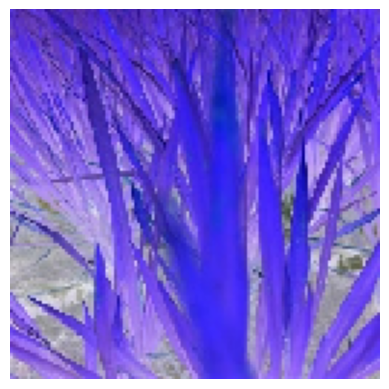

In [27]:
# Example usage"C:\Users\Nandan\Desktop\5g"
img_path = '/mnt/windows/Users/Nandan/Desktop/intern/Day 8 jan 11/processed_images/downy_mildew/100019.jpg'  # Replace with the actual test image path
predict_disease(img_path)

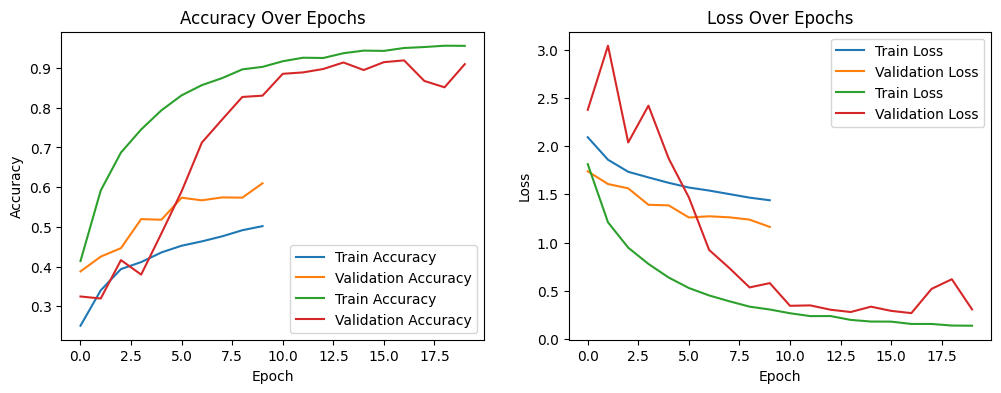

In [28]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine_tune.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine_tune.history['val_accuracy'], label='Validation Accuracy')

plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine_tune.history['loss'], label='Train Loss')
plt.plot(history_fine_tune.history['val_loss'], label='Validation Loss')

plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [1]:
import os
import random
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Path to the saved model file
model_path = "mobilenetv2_leaf_disease_model.h5"  # Replace with your model file path

# Load the trained model
model = load_model(model_path)
print("Model loaded successfully!")

# Class labels (update with your actual classes)
class_labels = [
    'bacterial_leaf_blight',
    'bacterial_leaf_streak',
    'bacterial_panicle_blight',
    'blast',
    'brown_spot',
    'dead_heart',
    'downy_mildew',
    'hispa',
    'normal',
    'tungro'
]
def preprocess_and_predict(img_path):
    """
    Preprocess the image and predict its class.

    Args:
        img_path (str): Path to the input image.

    Returns:
        tuple: Predicted class label and actual image array.
    """
    img_size = (128,128)  # Image size used during training
    
    # Load the image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Could not load image from path: {img_path}")
    
    # Convert the image to RGB (OpenCV loads images in BGR by default)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize the image
    img_resized = cv2.resize(img_rgb, img_size)
    
    # Normalize the image (scale pixel values to [0, 1])
    img_normalized = img_resized / 255.0
    
    # Add batch dimension
    img_array = np.expand_dims(img_normalized, axis=0)
    
    # Predict the class
    prediction = model.predict(img_array)
    predicted_class_idx = np.argmax(prediction, axis=-1)
    predicted_class = class_labels[predicted_class_idx[0]]
    
    return predicted_class, img_rgb

def evaluate_model(data_dir, sample_size=10):
    """
    Evaluate the model using a subset of images from each class.

    Args:
        data_dir (str): Path to the directory containing class folders.
        sample_size (int): Number of images to sample per class.

    Returns:
        None
    """
    correct_predictions = 0
    total_images = 0
    images_to_display = []

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue  # Skip non-folder files
        
        # Randomly sample images from the class folder
        image_files = os.listdir(class_path)
        sampled_files = random.sample(image_files, min(sample_size, len(image_files)))

        for img_name in sampled_files:
            img_path = os.path.join(class_path, img_name)
            predicted_class, img = preprocess_and_predict(img_path)
            actual_class = class_name
            
            # Check if the prediction is correct
            if predicted_class == actual_class:
                correct_predictions += 1
            
            total_images += 1
            images_to_display.append((img, predicted_class, actual_class))
    
    # Calculate accuracy
    accuracy = correct_predictions / total_images
    print(f"Model Accuracy: {accuracy:.2%}")

    # Display images with predictions
    cols = 5
    rows = (len(images_to_display) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    for ax, (img, predicted, actual) in zip(axes.flatten(), images_to_display):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"P: {predicted}\nA: {actual}", fontsize=8)
    plt.tight_layout()
    plt.show()

2025-01-13 14:06:58.241575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736757418.253286    4156 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736757418.256608    4156 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 14:06:58.269489: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1736757421.658941    4156 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 39

Model loaded successfully!


In [ ]:
# Path to the dataset directory
dataset_dir = "/mnt/windows/Users/Nandan/Desktop/intern/Day 8 jan 11/processed_images/"  # Update with your dataset path
#dataset_dir = '/mnt/windows/Users/Nandan/Desktop/intern/Day 8 jan 11/PADDY IMAGES 1000/'

evaluate_model(dataset_dir)

In [ ]:
import os
import random
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Define model and preprocessing parameters
IMG_SIZE = (128, 128)  # Model input size
BATCH_SIZE = 32

# Load your trained model
model_path = "mobilenetv2_leaf_disease_model.h5"
model = load_model(model_path)

# Parent directory containing class folders
parent_dir = "/mnt/windows/Users/Nandan/Desktop/intern/Day 8 jan 11/Paddy images 20/"  # Update this to your folder path

# Preprocessing function
def preprocess_image(image_path, target_size=(128, 128)):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Failed to load image at {image_path}")
        return None
    
    # Convert image to RGB (OpenCV loads as BGR)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Invert the color (RGB -> 255 - RGB)
    image_inverted = 255 - image_rgb
    
    # Resize image
    image_resized = cv2.resize(image_inverted, target_size)
    
    # Normalize the image (divide by 255 for pixel values between 0 and 1)
    image_normalized = image_resized / 255.0
    
    return image_normalized

# Find class folders
class_folders = [os.path.join(parent_dir, d) for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d))]
class_labels = [os.path.basename(folder) for folder in class_folders]

# Select 100 random images from all classes
image_paths = []
actual_classes = []
preprocessed_images = []

random.seed(200)
for class_label, folder in zip(class_labels, class_folders):
    # Get all images in the class folder
    image_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print(f"No images found in folder: {folder}")
        continue
    
    # Randomly select images (to make total 100 images)
    selected_images = random.sample(image_files, min(100 - len(image_paths), len(image_files)))
    
    for image_path in selected_images:
        preprocessed_image = preprocess_image(image_path)
        
        if preprocessed_image is not None:
            preprocessed_images.append(preprocessed_image)
            actual_classes.append(class_label)
            image_paths.append(image_path)

# Convert to NumPy array
preprocessed_images = np.array(preprocessed_images)
print(f"Shape of preprocessed images array: {preprocessed_images.shape}")

# Make predictions
predictions = model.predict(preprocessed_images, batch_size=BATCH_SIZE)

# Calculate accuracy
predicted_classes = np.argmax(predictions, axis=1)
true_classes = [class_labels.index(class_label) for class_label in actual_classes]

accuracy = np.mean(predicted_classes == true_classes)
print(f"Accuracy on 100 images: {accuracy * 100:.2f}%")

# Visualization (Fixed for up to 100 images)
names = [
    'bacterial_leaf_blight',
    'bacterial_leaf_streak',
    'bacterial_panicle_blight',
    'blast',
    'brown_spot',
    'dead_heart',
    'downy_mildew',
    'hispa',
    'normal',
    'tungro'
]

# Calculate grid size based on number of images
num_images = len(image_paths)
cols = 5  # 10 images per row
rows = (num_images // cols) + (num_images % cols != 0)  # If not divisible, add another row

plt.figure(figsize=(16, 2 * rows))
for i, (image_path, actual_class, prediction) in enumerate(zip(image_paths, actual_classes, predictions)):
    predicted_class = np.argmax(prediction)
    confidence = prediction[predicted_class]
    
    # Display image in grid
    plt.subplot(rows, cols, i + 1)
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    
    # Title with actual class, predicted class, and confidence
    title = f"Actual: {actual_class}\nPred: {names[predicted_class]} ({confidence:.2f})"
    plt.title(title)

plt.tight_layout()
plt.show()
